In [16]:
import os
import cv2
import numpy as np
import habitat
from env import Env
import quaternion
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!ln -s /data/ ./data

In [3]:
from arguments import init_config
config = init_config()

In [4]:
config['DATASET']['DATA_PATH'] = '/data/v1/{split}/{split}.json.gz'
config['DATASET']['SCENES_DIR'] = '/data'
config['DATASET']['SPLIT'] = 'train'
env = Env(config=config)
print("Environment creation successful")

2020-05-20 06:35:22,627 Initializing dataset PointNav-v1
2020-05-20 06:37:03,214 initializing sim Sim-v0
2020-05-20 06:37:07,667 Initializing task Nav-v0


Environment creation successful


In [5]:
res = env.reset()[0]

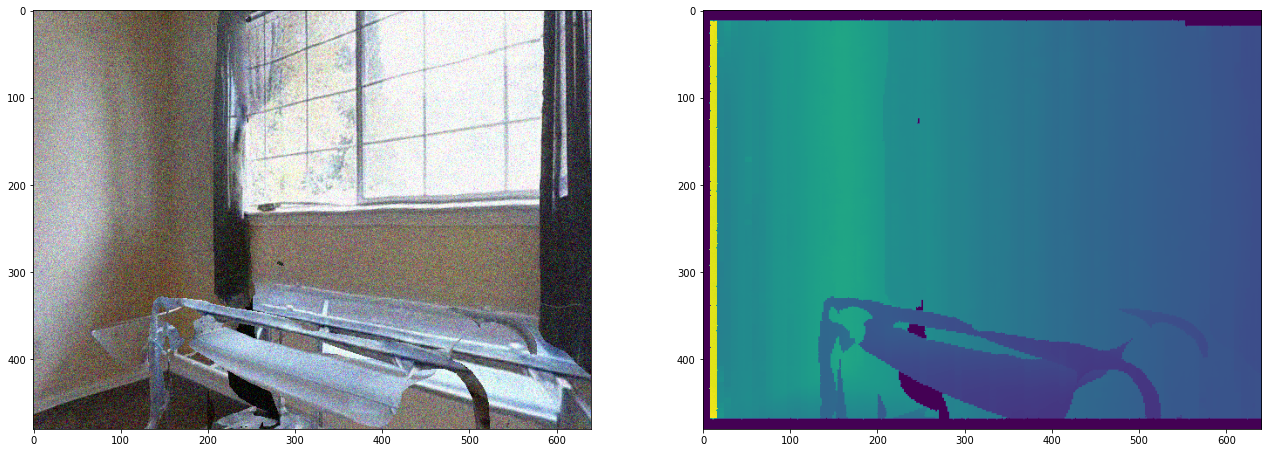

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(22, 10))
plt.subplot(121)
plt.imshow(res['rgb'])
plt.subplot(122)
plt.imshow(res['depth'][:,:,0])
plt.show()

Step #1:
--gps: [ 0.00873868 -0.06296452]
--pos: [2.683564098861284, -1.3011371224062618]
--compass: [0.27983433]


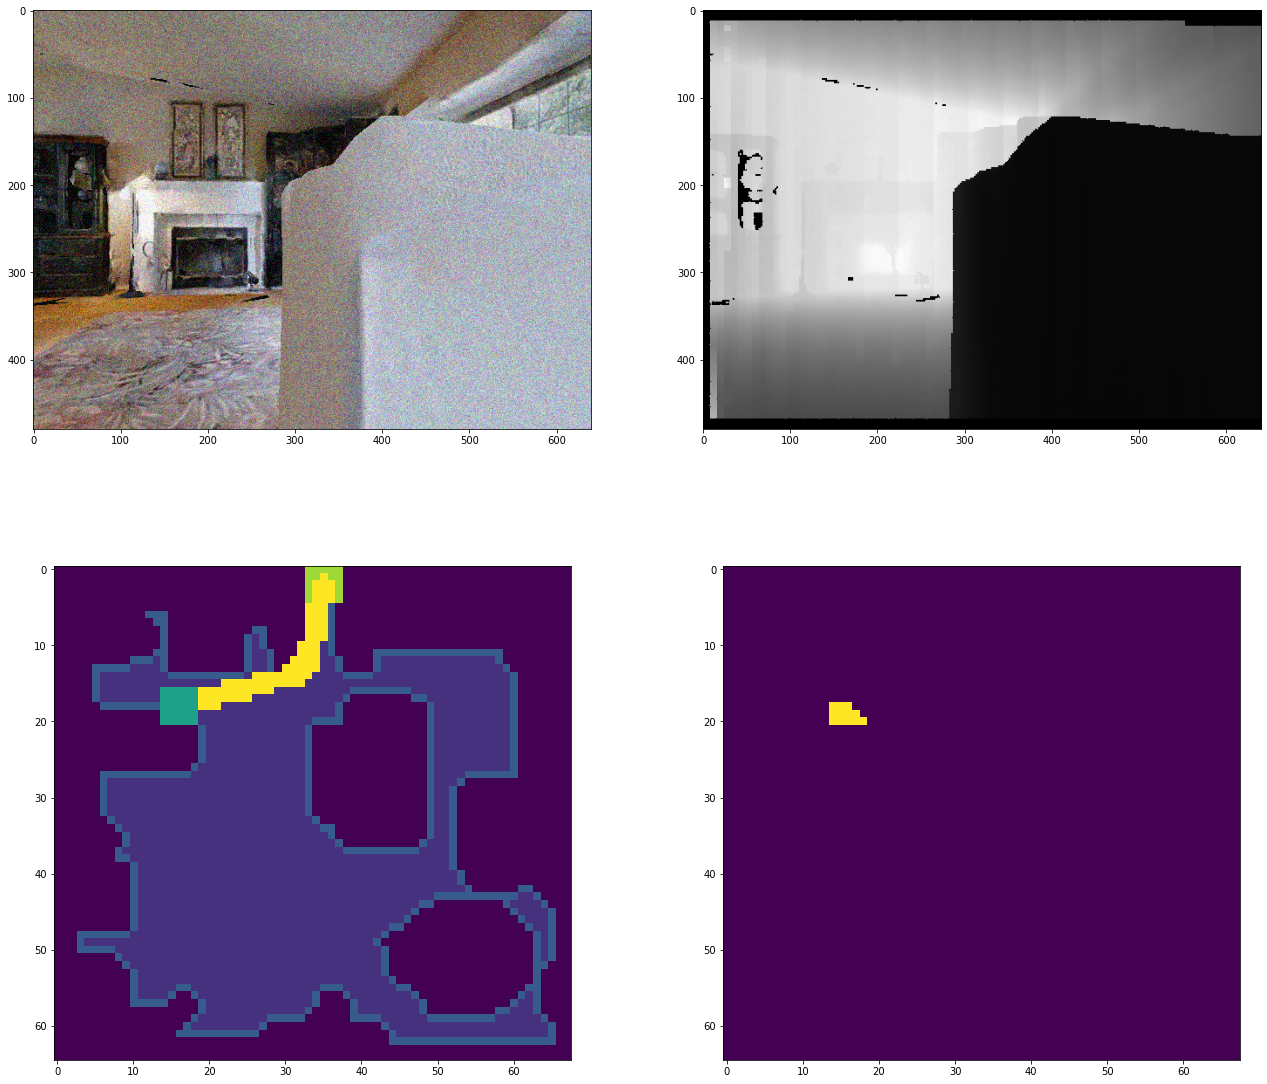

In [21]:
res = env.reset()[0]
done = False
ind = 0
while not done:
    observations, info, done = env.step(0, ideal_action=True)
    ind += 1
    print('Step #{}:\n--gps: {}\n--pos: {}\n--compass: {}'.format(ind, observations['gps'], observations['pos'], observations['compass']))
    
    fig, ax = plt.subplots(2, 2, figsize=(22, 20))
    plt.subplot(221)
    plt.imshow(observations['rgb'])
    plt.subplot(222)
    plt.imshow(observations['depth'][:,:,0], cmap='gray')
    plt.subplot(223)
    plt.imshow(info['top_down_map']['map'])
    plt.subplot(224)
    plt.imshow(info['top_down_map']['fog_of_war_mask'])
    plt.show()
    break

In [23]:
seq_num = 0
save_path = '/root/DF-VO/dataset/custom'

In [197]:
add_redun = 0
assert add_redun >= 0

!cd $save_path
seq_path = os.path.join(save_path, str(seq_num))
!mkdir $seq_path
rgb_path = os.path.join(seq_path, 'rgb')
depth_path = os.path.join(seq_path, 'depth')
!mkdir $rgb_path
!mkdir $depth_path

done = False
res = env.reset()[0]
pos_start = env.sim.get_agent_state().position
w, x, y, z = env.sim.get_agent_state().rotation.components
# q_rev = quaternion.quaternion(w,-x,-y,-z) / (w*w + x*x + y*y + z*z)
# global_rot = quaternion.quaternion(1,0,1,0) * q_rev
ind = 0
cv2.imwrite(os.path.join(rgb_path, '{:.06f}.png'.format(ind)), observations['rgb'])
cv2.imwrite(os.path.join(depth_path, '{:.06f}.png'.format(ind)), observations['depth']*255)
with open(os.path.join(seq_path, 'rgb.txt'), 'a') as f:
    f.write('{} {:.06f}.png\n'.format(ind, ind))
with open(os.path.join(seq_path, 'depth.txt'), 'a') as f:
    f.write('{} {:.06f}.png\n'.format(ind, ind))
with open(os.path.join(seq_path, 'groundtruth.txt'), 'a') as f:
    pos = env.sim.get_agent_state().position - pos_start
#     q = global_rot * env.sim.get_agent_state().rotation
    q = env.sim.get_agent_state().rotation
    f.write('{} {} {} {} {} {} {} {}\n'.format(ind, *pos, q.x, q.y, q.z, q.w))

while not done:
    if not ind % (add_redun + 1):
        observations, info, done = env.step(0, ideal_action=True)
    else:
        action = np.random.randint(1, 4)
        observations, info, done = env.step(action, ideal_action=False)
    ind += 1
    cv2.imwrite(os.path.join(rgb_path, '{:.06f}.png'.format(ind)), observations['rgb'])
    cv2.imwrite(os.path.join(depth_path, '{:.06f}.png'.format(ind)), observations['depth']*255)
    with open(os.path.join(seq_path, 'rgb.txt'), 'a') as f:
        f.write('{} {:.06f}.png\n'.format(ind, ind))
    with open(os.path.join(seq_path, 'depth.txt'), 'a') as f:
        f.write('{} {:.06f}.png\n'.format(ind, ind))
    with open(os.path.join(seq_path, 'groundtruth.txt'), 'a') as f:
        pos = env.sim.get_agent_state().position - pos_start
        # q = global_rot * env.sim.get_agent_state().rotation
        q = env.sim.get_agent_state().rotation
        f.write('{} {} {} {} {} {} {} {}\n'.format(ind, *pos, q.x, q.y, q.z, q.w))
    
seq_num += 1

In [186]:
w, x, y, z = 0.1, 0, 8, 0
w2, y2 = np.random.rand(2)
q1 = quaternion.quaternion(w,x,y,z)
q2 = quaternion.quaternion(w,-x,-y,-z) / (w*w + x*x + y*y + z*z)  # q1**-1
q3 = quaternion.quaternion(w2,x,y2,z)

In [187]:
q4 = quaternion.quaternion(1,0,1,0) * q2

In [188]:
q4 * q3

quaternion(0.167042502723138, 0, -0.00598072582568723, 0)